# Calculate Disperser transmission for simulation

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

## Setup

### import

In [1]:
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [2]:
import seaborn as sns

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Figure style

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [5]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [6]:
PATH_SPECTRACTOR='../../Spectractor'
PATH_SPECTRACTORSIM='../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../merra2'

In [7]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [8]:
from spectractorsim import *
from libspecana import *

thrpt_SimClearSky.csv
thrpt_AverClearSky.csv	
thrpt_Merra2Sky.csv	

thrpt_Ron400.csv
thrpt_Thor300.csv
thrpt_HoloPhP.csv	
thrpt_HoloPhAg.csv	
thrpt_HoloAmAg.csv	

In [9]:
all_files_30may17=["thrpt_Ron400.csv","thrpt_Thor300.csv","thrpt_HoloPhP.csv","thrpt_HoloPhAg.csv","thrpt_HoloAmAg.csv",
           "thrpt_SimClearSky.csv","thrpt_SimAverSky.csv","thrpt_SimMerra2Sky.csv"]

In [10]:
topdir="data"

In [11]:
subdir="30may17/HD111980"

In [12]:
path=os.path.join(topdir,subdir)

In [13]:
def GetLogDisperserTransm(thefile):
    df=pd.read_csv(thefile)
    
    X=df["wl"].values
    Y=df["thrpt"].values
    good_indexes=np.where(Y!=0)[0]
    X=X[good_indexes]
    Y=Y[good_indexes]
    return X,Y

In [14]:
def GetLogDisperserTransmwthErr(thefile):
    df=pd.read_csv(thefile)
    
    X=df["wl"].values
    Y=df["thrpt"].values
    EY=df["err"].values
    good_indexes=np.where(Y!=0)[0]
    X=X[good_indexes]
    Y=Y[good_indexes]
    EY=EY[good_indexes]
    return X,Y,EY

In [15]:
def Extrapolate(X,Y):
    # extrapolate X and Y
    YMIN=Y.min()-1.
    X=np.insert(X,0,X[0]-1)
    X=np.insert(X,0,WL[0])
    X=np.append(X,WL[-1])
 
    Y=np.insert(Y,0,YMIN)
    Y=np.insert(Y,0,YMIN)
    Y=np.append(Y,YMIN)
    return X,Y

In [16]:
def ExtrapolatewthErr(X,Y,EY):
    # extrapolate X and Y
    YMIN=Y.min()-1.
    EYMAX=EY.max()
    
    X=np.insert(X,0,X[0]-1)
    X=np.insert(X,0,WL[0])
    X=np.append(X,WL[-1])
 
    Y=np.insert(Y,0,YMIN)
    Y=np.insert(Y,0,YMIN)
    Y=np.append(Y,YMIN)
    
    EY=np.insert(EY,0,EYMAX)
    EY=np.insert(EY,0,EYMAX)
    EY=np.append(EY,EYMAX)
    
    return X,Y,EY

In [17]:
def GetLinearDisperserTrans(X,Y):
    X,Y=Extrapolate(X,Y)
    indexes=np.argsort(X)
    X=X[indexes]
    Y=Y[indexes]
    Y=smooth(Y,window_len=11)
    
    if(len(Y)>len(X)):
        Y=np.delete(Y, -1)
    elif(len(X)>len(Y)):
        X=np.delete(X, -1)
        
    
    #print len(X),len(Y)
    func = interpolate.interp1d(X, Y)   
    newY=np.power(10.,func(WL)/2.5)
    return WL,newY

In [18]:
def GetLinearDisperserTranswthErr(X,Y,EY):
    X,Y,EY=ExtrapolatewthErr(X,Y,EY)
    indexes=np.argsort(X)
    X=X[indexes]
    Y=Y[indexes]
    EY=EY[indexes]
    
    Y1=Y-EY
    Y2=Y+EY
    
    
    Y=smooth(Y,window_len=11)
    Y1=smooth(Y1,window_len=11)
    Y2=smooth(Y2,window_len=11)
   
    
    if(len(Y)>len(X)):
        Y=np.delete(Y, -1)
    elif(len(X)>len(Y)):
        X=np.delete(X, -1)
        
    if(len(Y1)>len(X)):
        Y1=np.delete(Y1, -1)
    if(len(Y2)>len(X)):
        Y2=np.delete(Y2, -1)
    
    #print len(X),len(Y),len(Y1),len(Y2)
    
  
    
    func = interpolate.interp1d(X, Y)   
    func1 = interpolate.interp1d(X, Y1) 
    func2 = interpolate.interp1d(X, Y2) 
    
    newY=np.power(10.,func(WL)/2.5)   
    newY1=np.power(10.,func1(WL)/2.5)
    newY2=np.power(10.,func2(WL)/2.5)
    
    
    return WL,newY,newY1,newY2

In [19]:
def plotMagnitude(X,Y,EY,thetitle):
    plt.plot(X,Y,'bo-')
    plt.fill_between(X,y1=Y-EY,y2=Y+EY,facecolor='grey',alpha=0.5)
    plt.grid()
    plt.legend()
    plt.xlabel("$\lambda$ (nm)")
    plt.ylabel("throughput (mag)")
    plt.title(thetitle)

In [20]:
def plotLinTransmission(X,Y,Y1,Y2,thetitle):
    plt.plot(X,Y,'b-')
    plt.errorbar(X,Y,yerr=np.abs(Y1-Y2)/2.,marker='.',color='blue',ecolor='red')
    plt.fill_between(X,y1=Y1,y2=Y2,facecolor='grey',alpha=0.5)
    plt.grid()
    plt.xlabel("$\lambda$ (nm)")
    plt.ylabel("relative throughput")
    plt.title(thetitle)

# Simulation

In [21]:
tel=TelescopeTransmission()
trans=tel.load_transmission()

In [22]:
tr=trans(WL)

In [23]:
thefilename1=os.path.join(path,all_files_30may17[5])
X1s,Y1s=GetLogDisperserTransm(thefilename1)

In [24]:
X0=X1s
Y0=Y1s

In [25]:
newX0,newY0=GetLinearDisperserTrans(X0,Y0)

In [26]:
thefilename2=os.path.join(path,all_files_30may17[6])
X2s,Y2s=GetLogDisperserTransm(thefilename2)

In [27]:
thefilename3=os.path.join(path,all_files_30may17[7])
X3s,Y3s=GetLogDisperserTransm(thefilename3)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0.5,1,'Optical Throughput in simulation')

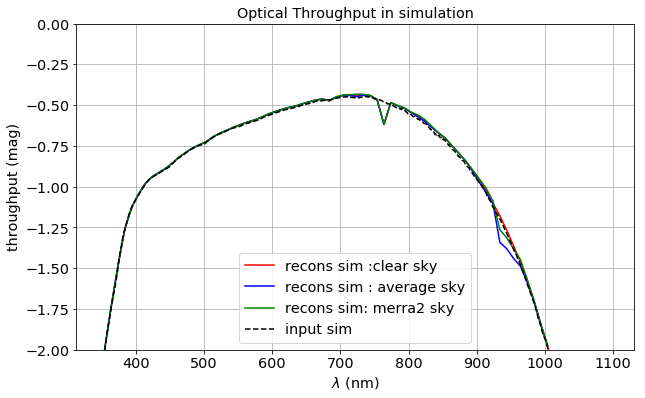

In [28]:
plt.plot(X1s,Y1s,'r-',label='recons sim :clear sky')
plt.plot(X2s,Y2s,'b-',label='recons sim : average sky')
plt.plot(X3s,Y3s,'g-',label='recons sim: merra2 sky')
plt.plot(WL,2.5*np.log10(tr),'k--',label='input sim')
plt.grid(True)
plt.ylim(-2.,0.)
plt.legend()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("throughput (mag)")
plt.title("Optical Throughput in simulation")

Text(0.5,1,'Optical Throughput in simulation')

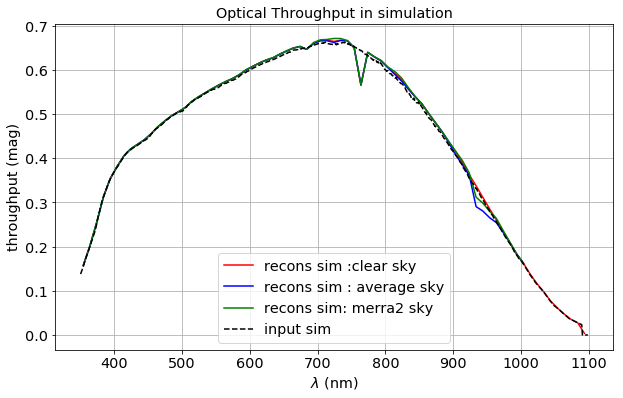

In [29]:
plt.plot(X1s,np.power(10.,Y1s/2.5),'r-',label='recons sim :clear sky')
plt.plot(X2s,np.power(10.,Y2s/2.5),'b-',label='recons sim : average sky')
plt.plot(X3s,np.power(10.,Y3s/2.5),'g-',label='recons sim: merra2 sky')
plt.plot(WL,tr,'k--',label='input sim')
plt.grid(True)
#plt.ylim(-2.,0.)
plt.legend()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("throughput (mag)")
plt.title("Optical Throughput in simulation")

# Ronchi400

In [30]:
thefilename=os.path.join(path,all_files_30may17[0])

In [31]:
X1,Y1,EY1=GetLogDisperserTransmwthErr(thefilename)

In [32]:
thetitle="Optical Throughput for Ronchi400"

2018-05-18 18:15:52  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


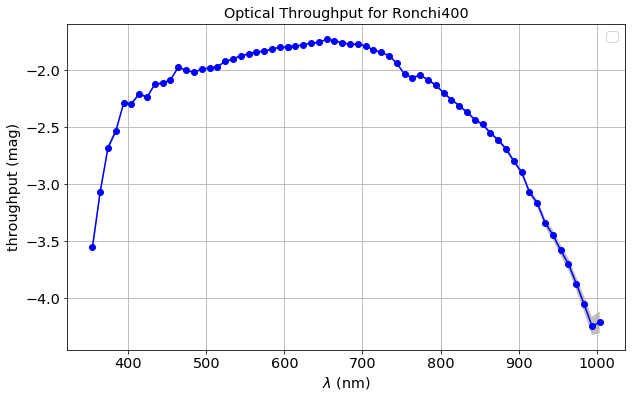

In [33]:
plotMagnitude(X1,Y1,EY1,thetitle)

In [34]:
newX1,newY1,newY1err,newY2err=GetLinearDisperserTranswthErr(X1,Y1,EY1)
newErr1=(newY2err-newY1err)/2.

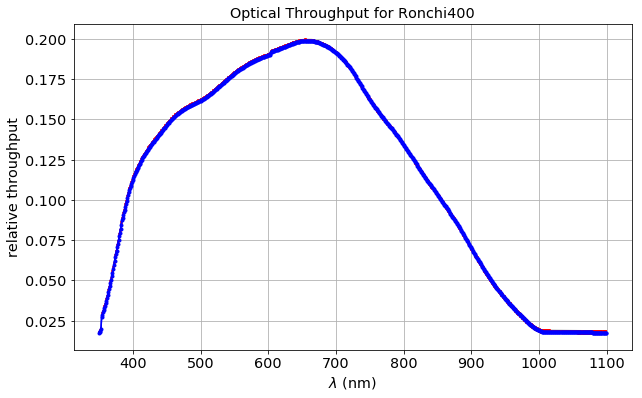

In [35]:
plotLinTransmission(newX1,newY1,newY1err,newY2err,thetitle)

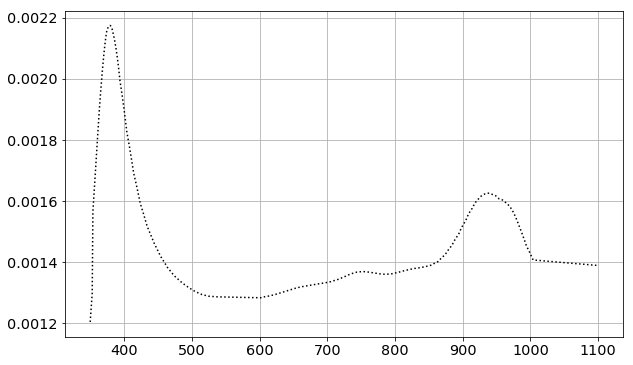

In [36]:
plt.plot(newX1,newErr1,'k:')
plt.grid()

# ThorLab

In [37]:
thefilename=os.path.join(path,all_files_30may17[1])

In [38]:
X2,Y2,EY2=GetLogDisperserTransmwthErr(thefilename)

In [39]:
thetitle="Optical Throughput for Thor300"

2018-05-18 18:15:53  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


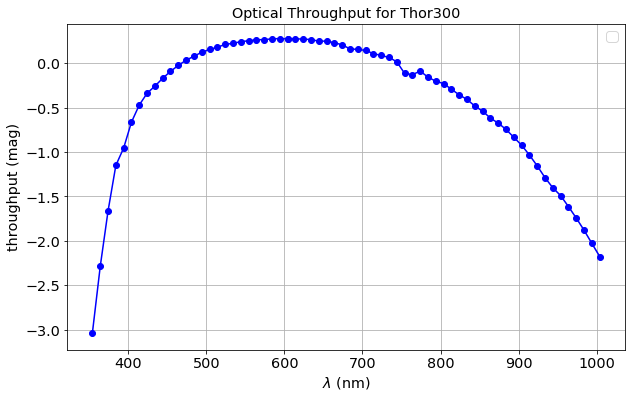

In [40]:
plotMagnitude(X2,Y2,EY2,thetitle)

In [41]:
newX2,newY2,newY1err,newY2err=GetLinearDisperserTranswthErr(X2,Y2,EY2)
newErr2=(newY2err-newY1err)/2.

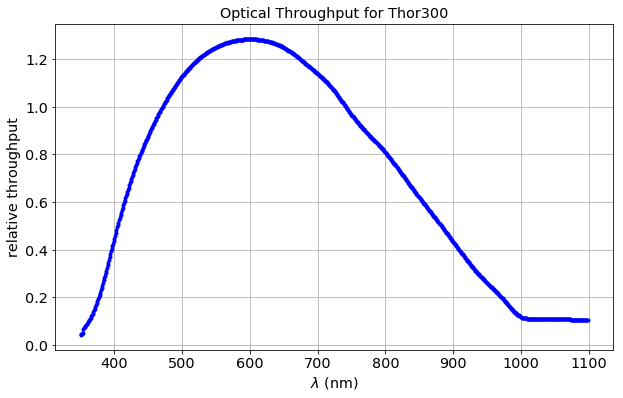

In [42]:
plotLinTransmission(newX2,newY2,newY1err,newY2err,thetitle)

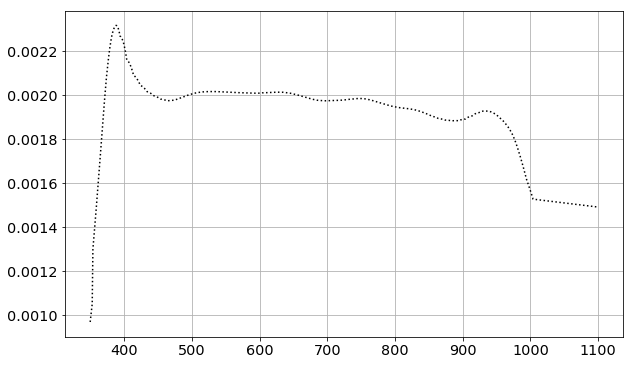

In [43]:
plt.plot(newX2,newErr2,'k:')
plt.grid()

# HoloPhP

In [44]:
thefilename=os.path.join(path,all_files_30may17[2])

In [45]:
X3,Y3,EY3=GetLogDisperserTransmwthErr(thefilename)

In [46]:
thetitle="Optical Throughput for HoloPhP"

2018-05-18 18:15:54  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


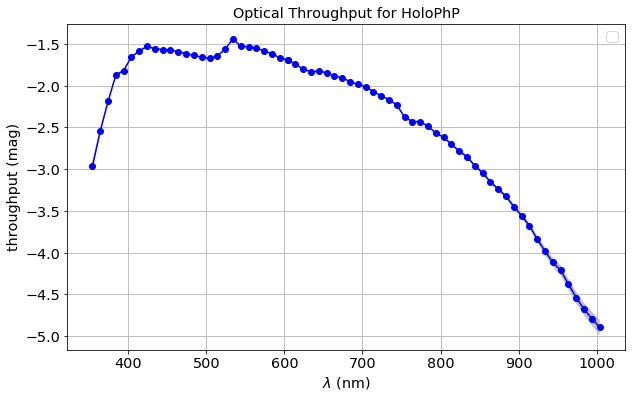

In [47]:
plotMagnitude(X3,Y3,EY3,thetitle)

In [48]:
newX3,newY3,newY1err,newY2err=GetLinearDisperserTranswthErr(X3,Y3,EY3)
newErr3=(newY2err-newY1err)/2.

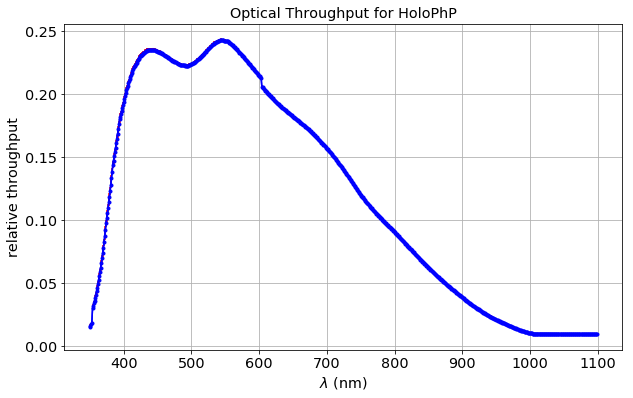

In [49]:
plotLinTransmission(newX3,newY3,newY1err,newY2err,thetitle)

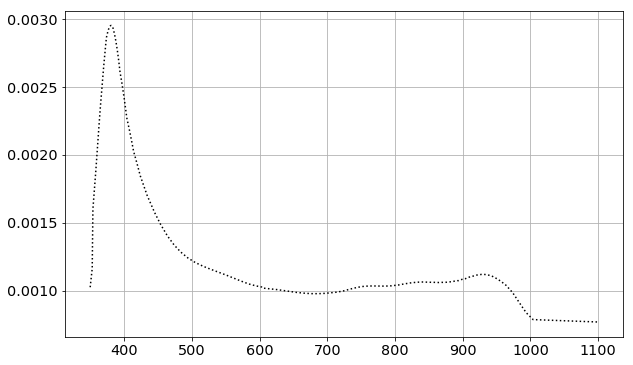

In [50]:
plt.plot(newX3,newErr3,'k:')
plt.grid()

# HoloPhAg

In [51]:
thefilename=os.path.join(path,all_files_30may17[3])

In [52]:
X4,Y4,EY4=GetLogDisperserTransmwthErr(thefilename)

In [53]:
thetitle="Optical Throughput for HoloPhAg"

2018-05-18 18:15:55  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


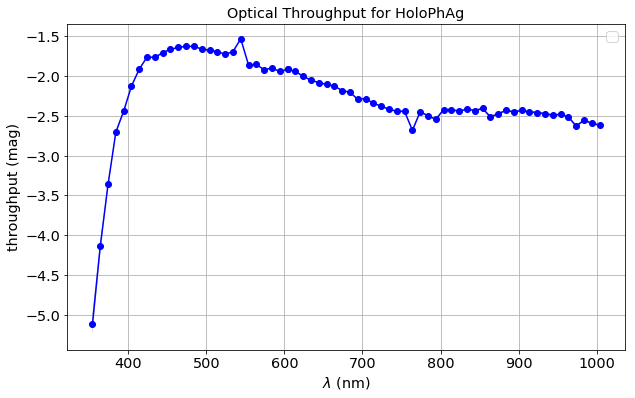

In [54]:
plotMagnitude(X4,Y4,EY4,thetitle)

In [55]:
newX4,newY4,newY1err,newY2err=GetLinearDisperserTranswthErr(X4,Y4,EY4)
newErr4=(newY2err-newY1err)/2.

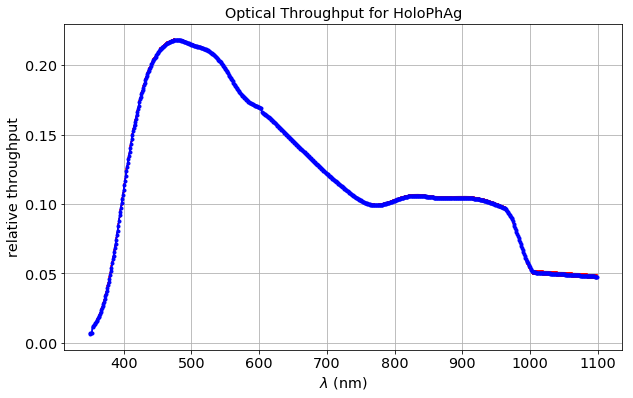

In [56]:
plotLinTransmission(newX4,newY4,newY1err,newY2err,thetitle)

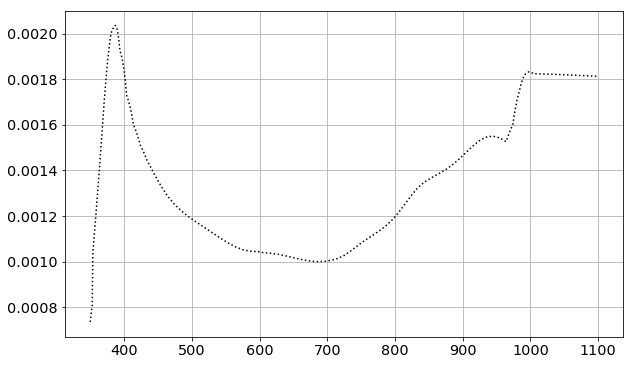

In [57]:
plt.plot(newX4,newErr4,'k:')
plt.grid()

# HoloAmAg

In [58]:
thefilename=os.path.join(path,all_files_30may17[4])

In [59]:
X5,Y5,EY5=GetLogDisperserTransmwthErr(thefilename)

In [60]:
thetitle="Optical Throughput for HoloAmAg"

2018-05-18 18:15:57  matplotlib.legend _parse_legend_args   WARNING No handles with labels found to put in legend.


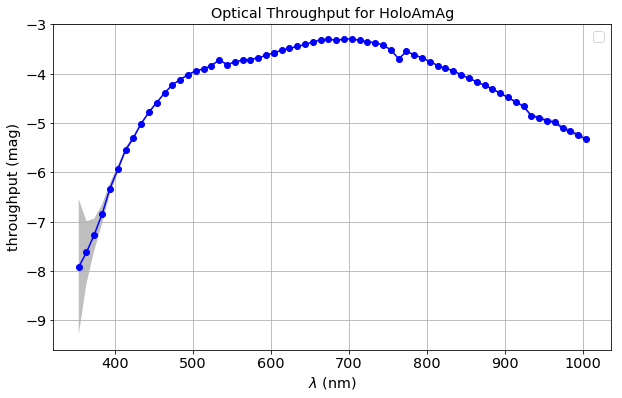

In [61]:
plotMagnitude(X5,Y5,EY5,thetitle)

In [62]:
newX5,newY5,newY1err,newY2err=GetLinearDisperserTranswthErr(X5,Y5,EY5)
newErr5=(newY2err-newY1err)/2.

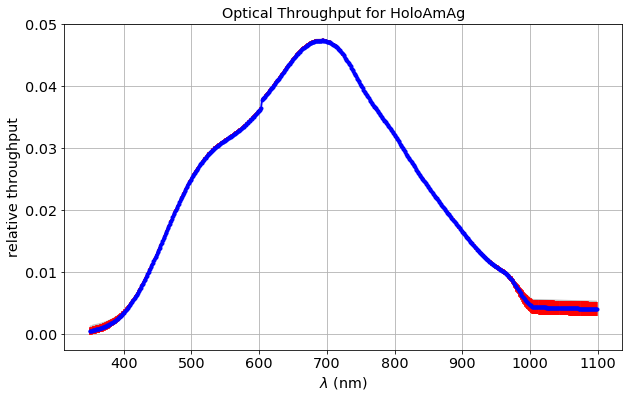

In [63]:
plotLinTransmission(newX5,newY5,newY1err,newY2err,thetitle)

In [64]:
newX5,newY5=GetLinearDisperserTrans(X5,Y5)

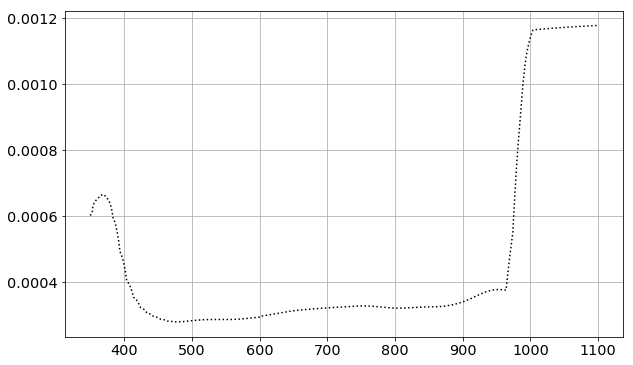

In [65]:
plt.plot(newX5,newErr5,'k:')
plt.grid()

# Data Frame

In [66]:
df=pd.DataFrame()

In [67]:
df["wl"]=WL
df["thrpt_ron400"]=newY1
df["thrpt_thor300"]=newY2
df["thrpt_holoPhP"]=newY3
df["thrpt_holoPhAg"]=newY4
df["thrpt_holoAmAg"]=newY5

In [68]:
df.head()

,wl,thrpt_ron400,thrpt_thor300,thrpt_holoPhP,thrpt_holoPhAg,thrpt_holoAmAg
0,350,0.017344,0.042159,0.015511,0.006453,0.000430
1,351,0.018088,0.043970,0.016475,0.006781,0.000443
2,352,0.018864,0.045858,0.017499,0.007126,0.000456
3,353,0.019673,0.047827,0.018586,0.007489,0.000469
4,354,0.027546,0.067376,0.030035,0.011240,0.000599


In [69]:
df.to_csv("disp_thrpt_300517_hd111980.csv")

# Disperser comparison

Text(0.5,1,'comparison of optical throughput')

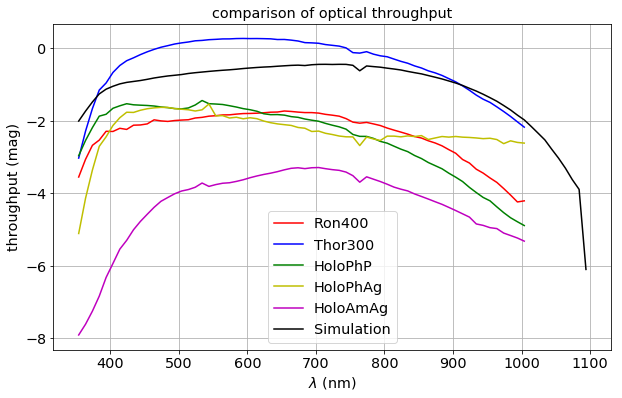

In [70]:
thetitle="comparison of optical throughput"
plt.plot(X1,Y1,'r-',label='Ron400')
plt.plot(X2,Y2,'b-',label='Thor300')
plt.plot(X3,Y3,'g-',label='HoloPhP')
plt.plot(X4,Y4,'y-',label='HoloPhAg')
plt.plot(X5,Y5,'m-',label='HoloAmAg')
plt.plot(X0,Y0,'k-',label='Simulation')
plt.legend()
plt.grid()
plt.legend()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("throughput (mag)")
plt.title(thetitle)

Text(0.5,1,'comparison of optical throughput')

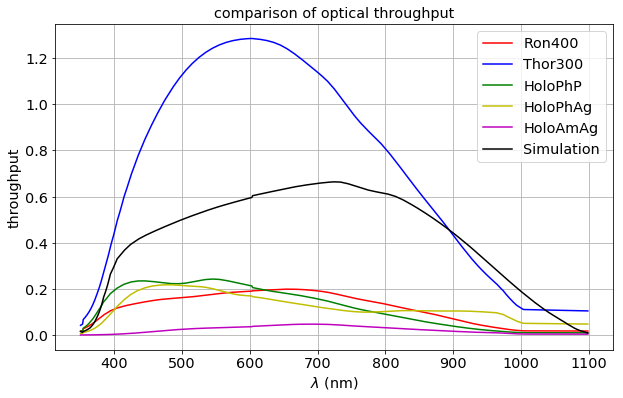

In [71]:
thetitle="comparison of optical throughput"
plt.plot(newX1,newY1,'r-',label='Ron400')
plt.plot(newX2,newY2,'b-',label='Thor300')
plt.plot(newX3,newY3,'g-',label='HoloPhP')
plt.plot(newX4,newY4,'y-',label='HoloPhAg')
plt.plot(newX5,newY5,'m-',label='HoloAmAg')
plt.plot(newX0,newY0,'k-',label='Simulation')
plt.legend()
plt.grid()
plt.legend()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("throughput")
plt.title(thetitle)

In [72]:
output_file='ctio_throughput_300517_v1.txt'
output_file_thor='ctio_ratioThorRon_300517_v1.txt'
output_file_php='ctio_ratioPhPRon_300517_v1.txt'
output_file_phag='ctio_ratioPhPRon_300517_v1.txt'
output_file_phag='ctio_ratioPhAgRon_300517_v1.txt'
output_file_amag='ctio_ratioAmAgRon_300517_v1.txt'

In [73]:
np.savetxt(output_file,np.c_[WL,newY1,newErr1])

In [74]:
R1=newY2/newY1
ER1=R1*np.sqrt((newErr1/newY1)**2+(newErr2/newY2)**2)
np.savetxt(output_file_thor,np.c_[WL,R1,ER1])

In [75]:
R2=newY3/newY1
ER2=R2*np.sqrt((newErr1/newY1)**2+(newErr3/newY3)**2)
np.savetxt(output_file_php,np.c_[WL,R2,ER2])

In [76]:
R3=newY4/newY1
ER3=R3*np.sqrt((newErr1/newY1)**2+(newErr4/newY4)**2)
np.savetxt(output_file_phag,np.c_[WL,R3,ER3])

In [77]:
R4=newY5/newY1
ER4=R4*np.sqrt((newErr1/newY1)**2+(newErr5/newY5)**2)
np.savetxt(output_file_amag,np.c_[WL,R4,ER4])

<ErrorbarContainer object of 3 artists>

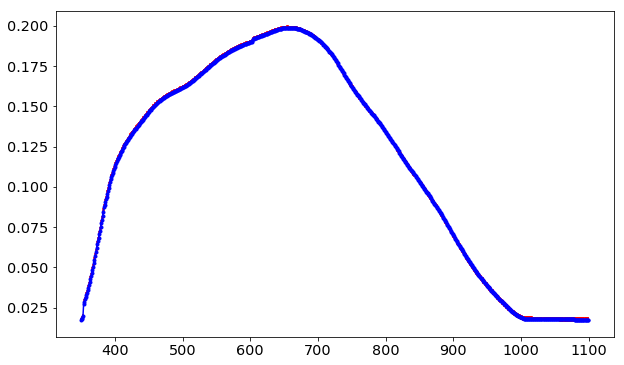

In [78]:
plt.errorbar(WL,newY1,yerr=newErr1,marker='.',color='blue',ecolor='red')

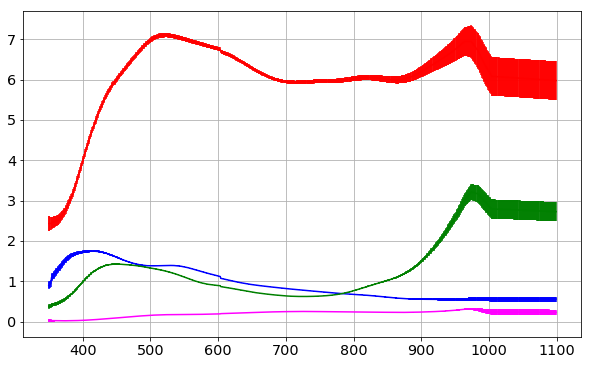

In [79]:
plt.errorbar(WL,R1,yerr=ER1,color='red')
plt.errorbar(WL,R2,yerr=ER2,color='blue')
plt.errorbar(WL,R3,yerr=ER3,color='green')
plt.errorbar(WL,R4,yerr=ER4,color='magenta')
plt.grid()